## Training Autoencoder with ignition events

**Status:** PUBLIC Distribution <br>
**File Name:** 01_Autoencoder_training_ignition_events.ipynb

**Author:** Jaume Manero / Darshana Upadhyay <br> 
**Date created:** 2023/06/19<br>
**Last modified:** 2023/06/19<br>
**Description:** Autoencoders for Forest Fire prediction

We train an autoencoder with a file with Ignition events. This is the first notebook. In this notebook we train the autoencoder to recognize ignition events. There is a map visualization of ignition events in BC

In [1]:
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Lambda, Input, Dense
from tensorflow.keras.losses import mse, binary_crossentropy, kl_divergence
from tensorflow.keras.optimizers.legacy import SGD,Adam,RMSprop
from tensorflow.keras import backend as K
from tensorflow import keras
from sklearn.preprocessing import normalize

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

2023-06-20 12:48:14.821326: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-20 12:48:14.947600: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-20 12:48:14.949438: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-20 12:48:17.047408: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Hyperparameters

NOISE = 0.5     # amount of noise to add to exercise 0.2
NETWORK = 'ANN'    # or ANN
THRESHOLD = 3      # 1: mean, 2: max, 3: deterministic
threshold_d = 0.06 # threshold for deterministic 0.05 and for min and max : 0.03

In [4]:
def label_marker(row):
    if isinstance(row['ignition'], str) and '0' in row['ignition']:
        return 0
    if isinstance(row['ignition'], str) and '1' in row['ignition']:
        return 1
    return 

In [3]:
path_normal = './Data/ignition_rows.csv'
ignition_df = pd.read_csv(path_normal)  
ignition_df.columns

Index(['date', 'lon', 'lat', 'u10', 'v10', 'd2m', 't2m', 'e', 'cvh', 'cvl',
       'skt', 'stl1', 'stl2', 'stl3', 'stl4', 'slt', 'sp', 'tp', 'swvl1',
       'swvl2', 'swvl3', 'swvl4', 'month', 'day', 'hour', 'ignition'],
      dtype='object')

In [6]:
ignition_df.drop(['lon', 'lat', 'date', 'ignition'], axis=1, inplace=True)

In [7]:
# each row of the dataframe is considered a sequence
# we create a numpy array with the sequences
ignition_np = ignition_df.to_numpy()
print('fire shape',ignition_np.shape)

fire shape (51918, 22)


In [8]:
ignition_df = ignition_df.replace([np.inf, -np.inf], 0)
scaler = MinMaxScaler()
ignition_scaled = scaler.fit_transform(ignition_df)

In [9]:
ignition_scaled.shape

(51918, 22)

In [10]:
# generate train set
# training set will consist of ignition dataset

len_ignition = len(ignition_scaled)
len_ignition_train = int(0.80 * len_ignition)
X_train = ignition_scaled[:len_ignition_train]

# generate test set consist of 50% attack and 50% normal

#X_test_norm = normal_scaled[len_norm_train:]
#len_attack_test = len(X_test_norm) # we will use the same number
#X_test_attack = attack_scaled[:len_attack_test]

#X_test = np.concatenate([X_test_norm, X_test_attack])
#X_test = X_test_attack
#y_test = np.ones(len(X_test))
#y_test[:len(X_test_norm)] = 0

In [11]:
X_train.shape

(41534, 22)

In [12]:
X_train

array([[0.42267023, 0.50302752, 0.50212552, ..., 0.        , 0.        ,
        0.39130435],
       [0.44453059, 0.56283466, 0.4587304 , ..., 0.        , 0.        ,
        0.65217391],
       [0.32381822, 0.65935569, 0.45729664, ..., 0.        , 0.        ,
        0.73913043],
       ...,
       [0.48608124, 0.44307419, 0.67404548, ..., 0.66666667, 0.03333333,
        0.47826087],
       [0.48913649, 0.41951   , 0.78651691, ..., 0.66666667, 0.03333333,
        0.52173913],
       [0.45885555, 0.3940384 , 0.669327  , ..., 0.66666667, 0.03333333,
        0.56521739]])

In [13]:
print(np.count_nonzero(np.isnan(X_train)))
X_train = np.nan_to_num(X_train)

1653


In [14]:
X_test.shape

NameError: name 'X_test' is not defined

In [15]:
y_test.shape

NameError: name 'y_test' is not defined

In [16]:
def get_error_term(v1, v2, _rmse=True):
    if _rmse:
        return np.sqrt(np.mean((v1 - v2) ** 2, axis=1))
    #return MAE
    return np.mean(abs(v1 - v2), axis=1)

In [17]:
# The reparameterization trick

def sample(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [18]:
original_dim = X_train.shape[1]
input_shape = (original_dim,)
intermediate_dim = int(original_dim / 2)
latent_dim = int(original_dim / 3)
intermediate_dim = 2048

In [19]:
# encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x      = Dense(intermediate_dim, activation='relu')(inputs)
x      = Dense(intermediate_dim/2, activation='relu')(x)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)
# use the reparameterization trick and get the output from the sample() function
z        = Lambda(sample, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
encoder  = Model(inputs, z, name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 22)]         0           []                               
                                                                                                  
 dense (Dense)                  (None, 2048)         47104       ['encoder_input[0][0]']          
                                                                                                  
 dense_1 (Dense)                (None, 1024)         2098176     ['dense[0][0]']                  
                                                                                                  
 z_mean (Dense)                 (None, 7)            7175        ['dense_1[0][0]']                
                                                                                            

In [20]:
# decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x             = Dense(intermediate_dim, activation='relu')(latent_inputs)
x             = Dense(intermediate_dim/2, activation='relu')(x)
outputs       = Dense(original_dim, activation='sigmoid')(x)
# Instantiate the decoder model:
decoder       = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_sampling (InputLayer)     [(None, 7)]               0         
                                                                 
 dense_2 (Dense)             (None, 2048)              16384     
                                                                 
 dense_3 (Dense)             (None, 1024)              2098176   
                                                                 
 dense_4 (Dense)             (None, 22)                22550     
                                                                 
Total params: 2,137,110
Trainable params: 2,137,110
Non-trainable params: 0
_________________________________________________________________


In [21]:
# full VAE model
outputs   = decoder(encoder(inputs))
vae_model = Model(inputs, outputs, name='vae_mlp')

In [22]:
# the KL loss function:
def vae_loss(x, x_decoded_mean):
    # compute the average MSE error, then scale it up, ie. simply sum on all axes
    reconstruction_loss = K.sum(K.square(x - x_decoded_mean))
    # compute the KL loss
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.square(K.exp(z_log_var)), axis=-1)
    # return the average loss over all 
    total_loss = K.mean(reconstruction_loss + kl_loss)    
    #total_loss = reconstruction_loss + kl_loss
    return total_loss

In [ ]:
opt = Adam(learning_rate=0.0001, clipvalue=0.5)
opt = RMSprop(learning_rate=0.0001)

vae_model.compile(optimizer=opt, loss=vae_loss)
vae_model.summary()

results = vae_model.fit(X_train, X_train,
                        shuffle=True,
                        epochs=500,
                        batch_size=128)

Model: "vae_mlp"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 22)]              0         
                                                                 
 encoder (Functional)        (None, 7)                 2159630   
                                                                 
 decoder (Functional)        (None, 22)                2137110   
                                                                 
Total params: 4,296,740
Trainable params: 4,296,740
Non-trainable params: 0
_________________________________________________________________
Train on 41534 samples
Epoch 1/500


2023-06-20 12:28:16.845999: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-20 12:28:16.847406: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-06-20 12:28:16.871321: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:353] MLIR V1 optimization pass is not enabled
2023-06-20 12:28:16.938242: W tensorflow/c/c_api.cc:300] Operation '{name:'training/RMSprop/dense_4/kernel/rms/Assign' id:588 op devi

41534/41534 [==============================] - 17s 413us/sample - loss: 44.6015
Epoch 2/500
41534/41534 [==============================] - 18s 442us/sample - loss: 24.1768
Epoch 3/500
41534/41534 [==============================] - 19s 449us/sample - loss: 21.8251
Epoch 4/500
41534/41534 [==============================] - 19s 454us/sample - loss: 20.5340
Epoch 5/500
41534/41534 [==============================] - 19s 460us/sample - loss: 19.9025
Epoch 6/500
41534/41534 [==============================] - 18s 444us/sample - loss: 19.4575
Epoch 7/500
41534/41534 [==============================] - 19s 449us/sample - loss: 19.0846
Epoch 8/500
41534/41534 [==============================] - 22s 540us/sample - loss: 18.8020
Epoch 9/500
41534/41534 [==============================] - 21s 501us/sample - loss: 18.5647
Epoch 10/500
41534/41534 [==============================] - 24s 567us/sample - loss: 18.3486
Epoch 11/500
41534/41534 [==============================] - 21s 503us/sample - loss: 18.239

In [1]:
plt.plot(results.history['loss'])
#plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');
plt.show()

NameError: name 'plt' is not defined

In [ ]:
### Fires Figure

In [9]:
BBox = ((ignition_df.lon.min(), ignition_df.lon.max(),
         ignition_df.lat.min(), ignition_df.lat.max()))

In [13]:
print('These are the Boundaries of our Plot', BBox)
# now extract from openstreetmap the png of the background and create an image 
map_1 = plt.imread('./Data/BC_map_ignition.png')  # Background map to generate a pretty picture

These are the Boundaries of our Plot (-122.0, -116.0, 49.0, 52.0)


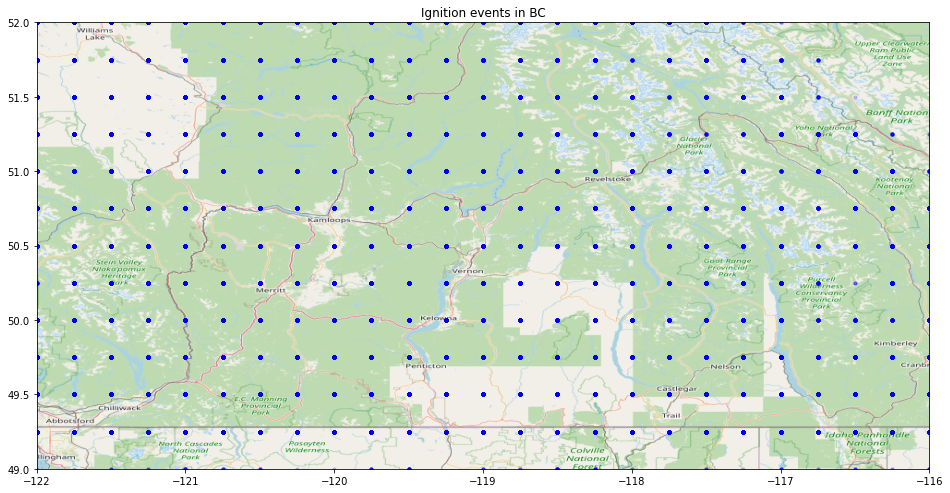

In [19]:
# map figure
fig, ax = plt.subplots(figsize=(16,14))
ax.scatter(ignition_df.lon, ignition_df.lat, zorder=1, alpha=0.2, c='b', s=10)
ax.set_title('Ignition events in BC')
ax.set_xlim(BBox[0], BBox[1])
ax.set_ylim(BBox[2], BBox[3])
ax.imshow(map_1, zorder=0, extent =BBox, aspect='equal')

In [64]:
X_train_pred = vae_model.predict(X_train)

C:\Users\darsh\anaconda3\lib\site-packages\keras\engine\training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [65]:
mae_vector = get_error_term(X_train_pred, X_train, _rmse=False)
print(f'Avg error {np.mean(mae_vector)}\nmedian error {np.median(mae_vector)}\n99Q: {np.quantile(mae_vector, 0.99)}')
print(f'setting threshold on { np.quantile(mae_vector, 0.99)} ')

error_thresh = np.quantile(mae_vector, 0.99)
error_thresh = np.quantile(mae_vector, 0.98)
print(error_thresh)

Avg error nan
median error nan
99Q: nan
setting threshold on nan 
nan


In [66]:
X_pred = vae_model.predict(X_test)
mae_vector = get_error_term(X_pred, X_test, _rmse=False)
anomalies = (mae_vector > error_thresh)

np.count_nonzero(anomalies) / len(anomalies)
print('total anomalies',len(anomalies))
print(np.count_nonzero(anomalies))

print('total y_test',len(y_test))
print(np.count_nonzero(y_test))

total anomalies 20768
0
total y_test 20768
10384


In [67]:
from sklearn.metrics import classification_report

print(classification_report(y_test, anomalies))

              precision    recall  f1-score   support

         0.0       0.50      1.00      0.67     10384
         1.0       0.00      0.00      0.00     10384

    accuracy                           0.50     20768
   macro avg       0.25      0.50      0.33     20768
weighted avg       0.25      0.50      0.33     20768



C:\Users\darsh\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\darsh\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\darsh\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [68]:
X_pred.shape

(20768, 25)

In [69]:
X_encoded = encoder.predict(X_test)

C:\Users\darsh\anaconda3\lib\site-packages\keras\engine\training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [70]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_transform = pca.fit_transform(X_encoded)

ValueError: Input X contains NaN.
PCA does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [ ]:
# comparison PCA transformations
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(18,4))
fig.suptitle('PCA transformations comparison',size=20)
sns.scatterplot(x=X_transform[:, 0], y=X_transform[:, 1], s=20, hue=mae_vector, ax=ax1)
ax1.set_xlabel('MAE Vector', size=16)
sns.scatterplot(x=X_transform[:, 0], y=X_transform[:, 1], s=20, hue=anomalies, ax=ax2)
ax2.set_xlabel('Anomalies', size = 16)
sns.scatterplot(x=X_transform[:, 0], y=X_transform[:, 1], s=10, hue=y_test, ax=ax3)
ax3.set_xlabel('y_test', size = 16)
plt.grid()
plt.show()

In [ ]:
plt.figure(figsize=(12, 10))
sns.scatterplot(x=X_transform[:, 0], y=X_transform[:, 1], s=20, hue=mae_vector)
plt.grid()
plt.show()

In [ ]:
plt.figure(figsize=(12, 10))
sns.scatterplot(x=X_transform[:, 0], y=X_transform[:, 1], s=20, hue=anomalies)
plt.grid()
plt.show()

In [ ]:
plt.figure(figsize=(12, 10))
sns.scatterplot(x=X_transform[:, 0], y=X_transform[:, 1], s=10, hue=y_test)
plt.grid()
plt.show()

In [ ]:
X_pred.shape

In [ ]:
# figure
error_df = pd.DataFrame({'Reconstruction_error': np.squeeze(mae_vector),
                        'True_class': y_test})

error_df = error_df.sample(frac=1).reset_index(drop=True)
threshold_fixed = 0.06
print(error_thresh)
groups = error_df.groupby('True_class')

fig, ax = plt.subplots(figsize=(18,6))
for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Attack" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for normal and attack data")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show()

In [ ]:
lobal_error = np.squeeze(mae_vector)
Attack_error = error_df[error_df['True_class']==1].Reconstruction_error.to_numpy()
Normal_error = error_df[error_df['True_class']==0].Reconstruction_error.to_numpy()
print(Attack_error.shape, Normal_error.shape)

In [ ]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(18,6))
fig.suptitle('Error distributions comparison between different traffic categories',
             size=20)
ax1.hist(Normal_error, bins=150, color='green', alpha=0.6)
ax1.set_xlabel('Normal error', size=14)
ax1.set_ylabel('No of samples', size = 14)
ax2.hist(Attack_error, bins=150, color='pink')
ax2.set_xlabel('Attack error', size = 14)
ax2.set_ylabel('No of samples', size = 14)
ax3.hist(Attack_error, bins=150, color='pink')
ax3.hist(Normal_error, bins=150, color='green', alpha=0.6)
ax3.set_xlabel('Normal and attack', size = 14)
ax3.set_ylabel('No of samples', size = 14)
plt.show()

In [ ]:
import session_info
session_info.show(html=False)

### 